link artigo : https://openaccess.thecvf.com/content_cvpr_2018/papers/Sun_Pix3D_Dataset_and_CVPR_2018_paper.pdf

link git : https://github.com/xingyuansun/pix3d

# Dataset

In [21]:
# The Pix3D dataset

# !git clone https://github.com/xingyuansun/pix3d.git
# %cd pix3d
# !./download_dataset.sh


In [22]:
import json
data_set = json.load(open('pix3d/pix3d.json'))

In [23]:
data_set[0]

{'img': 'img/bed/0001.png',
 'category': 'bed',
 'img_size': [395, 244],
 '2d_keypoints': [[[182.5, 147.09375],
   [174.5, 225.09375],
   [16.5, 111.09375],
   [-1.0, -1.0],
   [-1.0, -1.0],
   [324.5, 101.09375],
   [336.5, 51.09375],
   [226.5, 20.09375],
   [-1.0, -1.0],
   [352.5, 121.09375]],
  [[181.5, 165.09375],
   [181.5, 224.09375],
   [3.5, 112.09375],
   [5.5, 141.09375],
   [-1.0, -1.0],
   [352.5, 90.09375],
   [349.5, 34.09375],
   [196.5, 26.09375],
   [-1.0, -1.0],
   [346.5, 114.09375]],
  [[171.5, 139.09375],
   [175.5, 227.09375],
   [29.5, 90.09375],
   [-1.0, -1.0],
   [-1.0, -1.0],
   [340.5, 80.09375],
   [351.5, 32.09375],
   [198.5, 22.09375],
   [-1.0, -1.0],
   [268.5, 79.09375]]],
 'mask': 'mask/bed/0001.png',
 'img_source': 'ikea',
 'model': 'model/bed/IKEA_MALM_2/model.obj',
 'model_raw': None,
 'model_source': 'ikea',
 '3d_keypoints': 'model/bed/IKEA_MALM_2/3d_keypoints.txt',
 'voxel': 'model/bed/IKEA_MALM_2/voxel.mat',
 'rot_mat': [[0.7813941591465821, 

In [24]:
data_set[0]['img']

'img/bed/0001.png'

In [25]:
# prompt: Ler um arquivo .mat e mostrar o que está contido nele

import scipy.io as sio

PREFIX = "pix3d/"

# Load the .mat file
data = sio.loadmat(PREFIX+data_set[0]['voxel'])

# Print the contents of the file
print(data['voxel'])

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


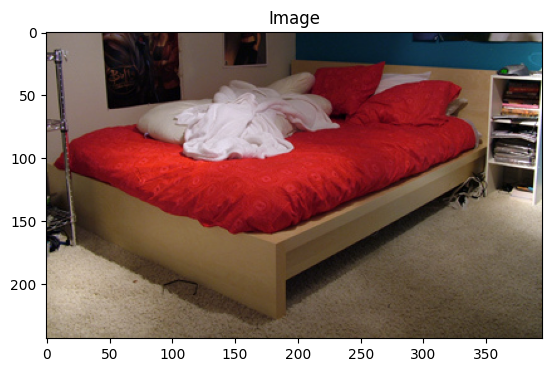

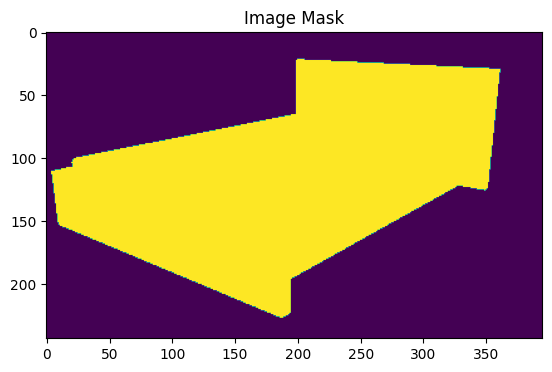

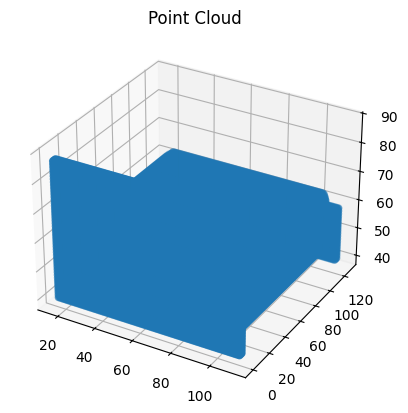

In [26]:
# prompt: carregar imagens e mostrar as nuvens de pontos

import json
import os
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

# Load an image and its corresponding point cloud
image_filename = PREFIX + data_set[0]['img']
image_mask_filename = PREFIX + data_set[0]['mask']
point_cloud_filename = PREFIX + data_set[0]['3d_keypoints']

image = Image.open(image_filename)
image_mask = Image.open(image_mask_filename)
# point_cloud = np.loadtxt(point_cloud_filename)
point_cloud = np.array(data['voxel'])

# Show the image
plt.imshow(image)
plt.title('Image')
plt.show()

# Show the image mask
plt.imshow(image_mask)
plt.title('Image Mask')
plt.show()


cloud = []
cloud = np.array((point_cloud.flatten() == 1).nonzero())
cloud = np.stack((cloud // (128*128), (cloud % (128*128)) // 128, cloud % 128), axis=-1).squeeze()

# Show the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cloud[:, 0], cloud[:, 1], cloud[:, 2], s=20)
plt.title('Point Cloud')
plt.show()


In [27]:
import torch
from torch import nn, optim
from torchvision.transforms import v2
from torchvision.io import read_image

In [28]:
from data.dataloader import train_loader, test_loader, val_loader

In [29]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [30]:
from model.model import Rec3D, transforms
model = Rec3D().to(device)

In [31]:
model

Rec3D(
  (vgg_pretrained): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
     

In [32]:
EPOCHS = 10
lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn_1 = nn.MSELoss()
loss_fn_2 = nn.MSELoss()

In [33]:
train_losses = [list(), list()]
valid_losses = [list(), list()]

In [45]:
def train_step(model, loader, loss_fn_1, loss_fn_2, optimizer, device) -> float:
  train_loss = [0, 0]
  for X, Y_mask, Y_cloud in loader:
    if X.shape == (1,1):
      continue
    # X = transforms(X)
    model.zero_grad()
    y_pred = model(X.to(device), torch.rand((1,128,128,128)).to(device))
    loss_1 = loss_fn_1(y_pred[0], Y_mask.to(device))
    loss_2 = loss_fn_2(y_pred[1], Y_cloud.unsqueeze(dim=0).to(device))
    loss_1.backward(retain_graph=True)
    loss_2.backward()
    optimizer.step()
    train_loss[0] +=  loss_1.item()
    train_loss[1] +=  loss_2.item()
  train_loss[0] /= len(loader)
  train_loss[1] /= len(loader)
  return train_loss


def validation_step(model, loader, loss_fn_1, loss_fn_2, device) -> float:
  loss = [0, 0]
  with torch.no_grad():
    for X, Y_mask, Y_cloud in loader:
      if X.shape == (1,1):
        continue
      # X = transforms(X)
      y_pred = model(X.to(device), torch.rand((1,128,128,128)).to(device))
      loss_1 = loss_fn_1(y_pred[0], Y_mask.to(device)).item() 
      loss_2 = loss_fn_2(y_pred[1], Y_cloud.to(device)).item()
      loss[0] += loss_1
      loss[1] += loss_2
  loss[0] /= len(loader)
  loss[1] /= len(loader)
  return loss

In [46]:
from tqdm import tqdm
from copy import deepcopy

resize_mask = v2.Resize((224, 224), interpolation=v2.InterpolationMode.NEAREST)
data = [(
  read_image(image_filename),
  resize_mask(read_image(image_mask_filename)).type(torch.FloatTensor),
  torch.FloatTensor(point_cloud)
)]

def train_model():
  for epoch in tqdm(range(EPOCHS)):
    train_loss = train_step(model, train_loader, loss_fn_1, loss_fn_2, optimizer, device)
    train_losses[0].append(train_loss[0])
    train_losses[1].append(train_loss[1])
    valid_loss = validation_step(model, val_loader, loss_fn_1, loss_fn_2, device)
    valid_losses[0].append(valid_loss[0])
    valid_losses[1].append(valid_loss[1])
    if valid_losses[-1] == min(valid_losses):
      best_model = deepcopy(model)
  return best_model

In [47]:
model.freeze_encoder_block()
best_model = train_model()

100%|██████████| 10/10 [8:00:05<00:00, 2880.55s/it] 


: 

In [48]:
model.unfreeze_encoder_block()
best_model = train_model()

  0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Rafael (Aluízio)\Documents\GitHub\rna_project\rna\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 1, 128, 128, 128])) that is different to the input size (torch.Size([1, 128, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 1/10 [48:00<7:12:06, 2880.76s/it]

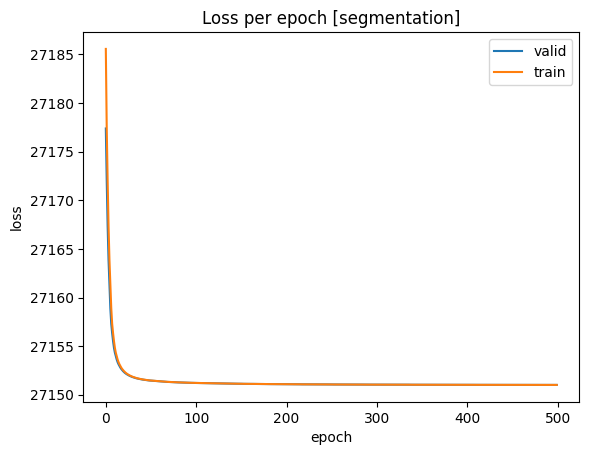

In [ ]:
def plot_loss(loss_train, loss_valid):
  plt.plot(loss_valid[0], label='valid')
  plt.plot(loss_train[0], label='train')
  plt.title('Loss per epoch [segmentation]')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend()
  plt.show()

plot_loss(train_losses, valid_losses)

In [ ]:
def plot_loss(loss_train, loss_valid):
  plt.plot(loss_valid[1], label='valid')
  plt.plot(loss_train[1], label='train')
  plt.title('Loss per epoch [reconstruction]')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend()
  plt.show()

plot_loss(train_losses, valid_losses)

In [ ]:
X = transforms(data[0][0]).unsqueeze(dim=0)
with torch.no_grad():
    y = best_model(X.to(device), torch.zeros((1,128,128,128)).to(device))

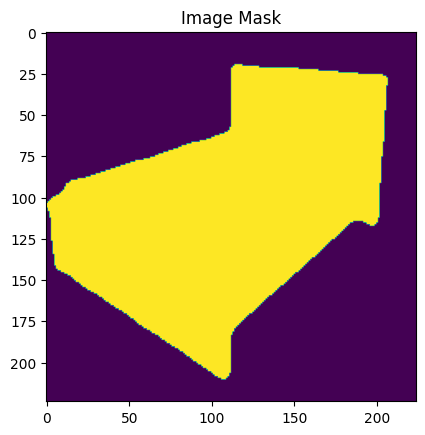

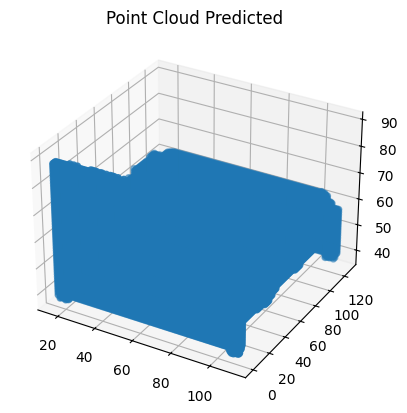

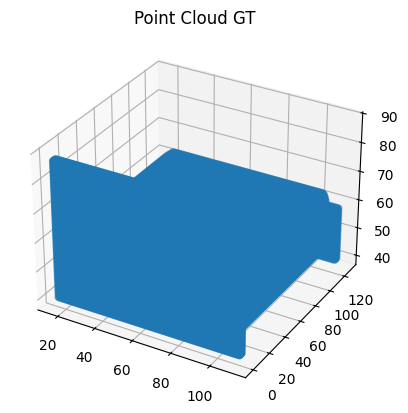

In [ ]:
# Show the image mask
plt.imshow((y[0].squeeze() > 0.7).cpu().numpy().astype(np.uint8))
plt.title('Image Mask')
plt.show()


cloud = []
t = (y[1].flatten() >= 0.5).nonzero(as_tuple=True)[0]
t = torch.stack((t // (128*128), (t % (128*128))//128, t % 128), dim=1)
cloud = t.cpu().numpy()

# Show the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cloud[:, 0], cloud[:, 1], cloud[:, 2], s=20)
plt.title('Point Cloud Predicted')
plt.show()


cloud = []
t = (data[0][2].flatten() >= 0.15).nonzero(as_tuple=True)[0]
t = torch.stack((t // (128*128), (t % (128*128))//128, t % 128), dim=1)
cloud = t.cpu().numpy()

# Show the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cloud[:, 0], cloud[:, 1], cloud[:, 2], s=20)
plt.title('Point Cloud GT')
plt.show()


In [ ]:
torch.save(best_model.state_dict(), "model/weights/weights.pdf")